In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from IPython.display import display

In [8]:
import os
ruta = os.path.abspath(r"C2425-R4\data\processed\peleadores.parquet")
ruta = os.path.join(os.getcwd(), "..", "..", "data", "processed", "peleadores.parquet")
df = pd.read_parquet(ruta)
df.head()

In [10]:
print("\nTipos de datos:")
print(df.dtypes.to_string())


Tipos de datos:
Unnamed: 0                                       int64
Nombre                                          object
Striking accuracy (%)                           object
Efectividad de derribo (%)                      object
Golpes Significativos Conectados               float64
Golpes Significativos Intentados               float64
Derribos conseguidos                           float64
Derribos intentados                            float64
Golpes Significativos Conectados Por Minuto    float64
Golpes Significativos Recibidos Por Minuto     float64
Promedio de Knockdown Por 15m                  float64
Promedio de Sumisión Por 15m                   float64
Defensa de Golpes Sig.                          object
Defensa De Derribo                              object
Promedio de Tiempo de Pelea                     object
Golpes De Pie                                    int64
Porcentaje De Pie                               object
Golpes Clinch                                   

In [12]:
"""SUB (Sumisiones): Tiene una distribución altamente sesgada a la derecha, con la mayoría de los valores concentrados 
en los niveles más bajos y algunos valores extremadamente altos, 
lo que indica que la mayoría de los peleadores consiguen pocas sumisiones en sus carreras."""

print("\nResumen estadístico de columnas numéricas:")
pd.set_option('display.max_columns', None)
print(df.describe(include='all'))


Resumen estadístico de columnas numéricas:
         Unnamed: 0       Nombre Striking accuracy (%)  \
count   2774.000000         2774                  2687   
unique          NaN         2772                    79   
top             NaN  BRUNO SILVA                   50%   
freq            NaN            2                   123   
mean    1386.500000          NaN                   NaN   
std      800.929148          NaN                   NaN   
min        0.000000          NaN                   NaN   
25%      693.250000          NaN                   NaN   
50%     1386.500000          NaN                   NaN   
75%     2079.750000          NaN                   NaN   
max     2773.000000          NaN                   NaN   

       Efectividad de derribo (%)  Golpes Significativos Conectados  \
count                        2391                       2687.000000   
unique                         72                               NaN   
top                           42%             

In [14]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
print(numerical_columns)

Index(['Unnamed: 0', 'Golpes Significativos Conectados',
       'Golpes Significativos Intentados', 'Derribos conseguidos',
       'Derribos intentados', 'Golpes Significativos Conectados Por Minuto',
       'Golpes Significativos Recibidos Por Minuto',
       'Promedio de Knockdown Por 15m', 'Promedio de Sumisión Por 15m',
       'Golpes De Pie', 'Golpes Clinch', 'Golpes Suelo', 'Golpes Cabeza',
       'Golpes Pierna', 'KO/TKO', 'DEC', 'SUB', 'Age', 'Height', 'Weight',
       'Reach', 'Leg Reach'],
      dtype='object')


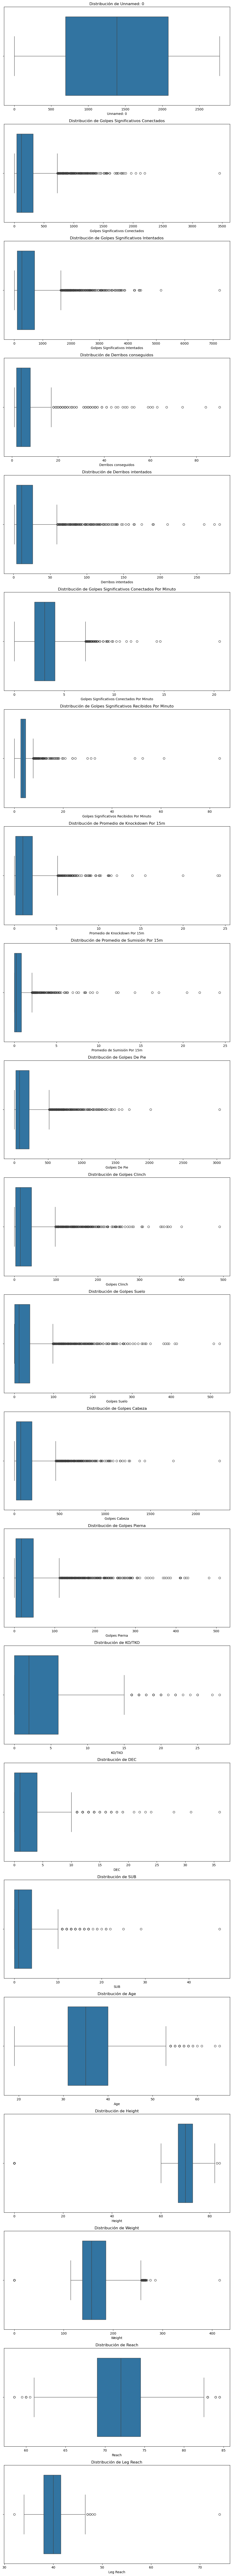

'Distribución sesgada a la derecha: La mayoría de los valores están concentrados \nen la parte baja de la escala, mientras que hay una gran cantidad de valores atípicos (outliers) hacia \nla derecha. Esto indica que la mayoría de los peleadores conectan pocos golpes significativos, \npero hay algunos casos excepcionales donde se conectan muchos. Para mejorar eso deberíamos estudiar realizar ciertas transformaciones.'

In [16]:
plt.figure(figsize=(10, 5 * len(numerical_columns)))
for i, col in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns), 1, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f"Distribución de {col}")

plt.tight_layout()
plt.show()
"""Distribución sesgada a la derecha: La mayoría de los valores están concentrados 
en la parte baja de la escala, mientras que hay una gran cantidad de valores atípicos (outliers) hacia 
la derecha. Esto indica que la mayoría de los peleadores conectan pocos golpes significativos, 
pero hay algunos casos excepcionales donde se conectan muchos. Para mejorar eso deberíamos estudiar realizar ciertas transformaciones."""


In [18]:
# Identificación de valores atípicos usando IQR
outliers = {}
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers[col] = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)][col]

# Mostrar las columnas con sus respectivos outliers
for col, outlier_values in outliers.items():
    print(f"{col} tiene {len(outlier_values)} outliers")
    print(outlier_values.head(5))  # Muestra solo los primeros 5 valores atípicos para cada columna



Unnamed: 0 tiene 0 outliers
Series([], Name: Unnamed: 0, dtype: int64)
Golpes Significativos Conectados tiene 209 outliers
3     1271.0
28    1065.0
32    1549.0
33     798.0
42     771.0
Name: Golpes Significativos Conectados, dtype: float64
Golpes Significativos Intentados tiene 202 outliers
3     2639.0
28    2667.0
32    3325.0
33    1713.0
69    2648.0
Name: Golpes Significativos Intentados, dtype: float64
Derribos conseguidos tiene 92 outliers
13     19.0
80     52.0
82     33.0
133    23.0
162    19.0
Name: Derribos conseguidos, dtype: float64
Derribos intentados tiene 197 outliers
13     68.0
58     97.0
64     68.0
76     79.0
78    102.0
Name: Derribos intentados, dtype: float64
Golpes Significativos Conectados Por Minuto tiene 62 outliers
112    8.92
118    7.27
127    8.34
128    8.07
154    7.17
Name: Golpes Significativos Conectados Por Minuto, dtype: float64
Golpes Significativos Recibidos Por Minuto tiene 135 outliers
12    11.25
47    10.11
63     9.25
90    12.13
99  

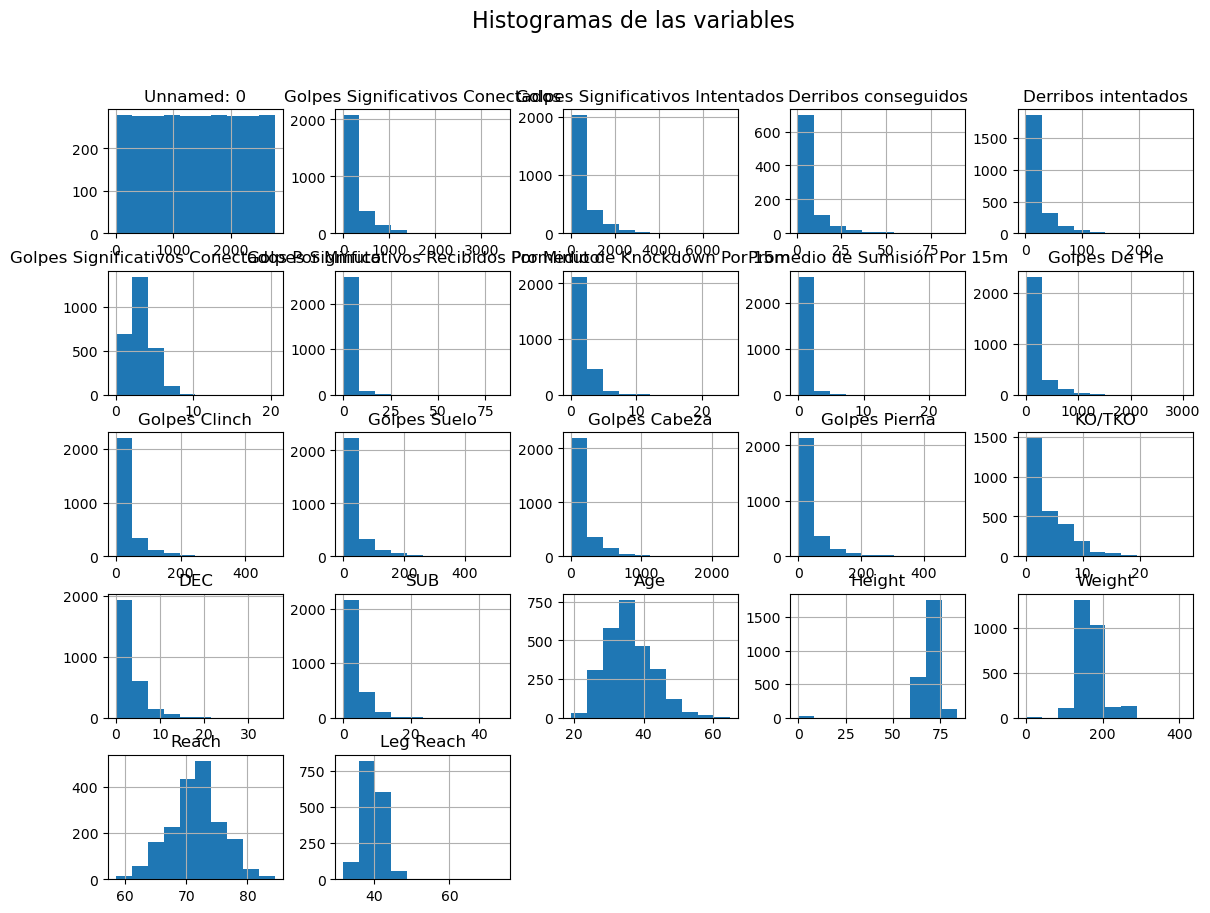

'Como vemos en los histogramas las variables no siguen distribuciones normales\ny predomina, como ya habíamos visto con los boxplots las colas hacía la derecha. Intentaremos\nutilizar todos los datos ya que no parecen errores de la página y en caso de que sea un problema para el \nmodelo eliminaremos algunos valores atípicos.'

In [20]:
df.hist(figsize=(14, 10))
plt.suptitle("Histogramas de las variables", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

"""Como vemos en los histogramas las variables no siguen distribuciones normales
y predomina, como ya habíamos visto con los boxplots las colas hacía la derecha. Intentaremos
utilizar todos los datos ya que no parecen errores de la página y en caso de que sea un problema para el 
modelo eliminaremos algunos valores atípicos."""

In [26]:
# Calcular el Z-score para todas las columnas numéricas
z_scores = df[numerical_columns].apply(zscore)

# Identificar valores con Z-score mayor a 3 o menor a -3
outliers_z = (z_scores.abs() > 3)

# Mostrar cuántos outliers hay en cada columna
outliers_count = outliers_z.sum()
print("\nNúmero de outliers detectados con Z-score:")
print(outliers_count[outliers_count > 0])


Número de outliers detectados con Z-score:
Golpes De Pie    62
Golpes Clinch    61
Golpes Suelo     60
Golpes Cabeza    57
Golpes Pierna    67
KO/TKO           42
DEC              35
SUB              43
dtype: int64
